# **Ant run study with Imitation Learning**

In [4]:
# Set up of virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
# Necessary imports

import gymnasium as gym
from gymnasium import wrappers
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [7]:
def plot(
    xs_list,
    means_list,
    stds_list,
    losses_list,
    labels_list=None,
    min=None,
    running_average=5,
):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    if labels_list is None:
        labels_list = [f"Agent {idx}" for idx in range(len(means_list))]
    for xs, means, stds, losses, label in zip(
        xs_list, means_list, stds_list, losses_list, labels_list
    ):
        kernel = np.ones(running_average) / running_average
        means_convolved = np.convolve(means, kernel, mode="same")
        stds_convolved = np.convolve(stds, kernel, mode="same")
        ax[0].plot(xs, means_convolved, label=label)
        ax[0].fill_between(
            xs,
            np.array(means_convolved) - np.array(stds_convolved),
            np.array(means_convolved) + np.array(stds_convolved),
            alpha=0.5,
        )
        ax[1].plot(xs, losses, label=label)
    if min is not None:
        ax[0].set_ylim(min, None)
    ax[0].legend()
    ax[0].set_ylabel("Reward")
    ax[1].set_ylabel("Loss")

    return fig, ax

In [8]:
class ExpertAgent(torch.nn.Module):
    def __init__(self, filename):
        super().__init__()
        self._network = torch.load(filename)
        self._network.eval()

    def get_action(self, obs: np.array):
        """
        Get action from the expert agent.

        Args:
            obs: np.array of shape (state_dim,)
        Returns:
            action: np.array of shape (action_dim,)
        """
        obs = torch.tensor(obs, dtype=torch.float32)
        return self._network(obs).cpu().detach().numpy()

## **I)Getting started with RL**
We will be using the [Ant-v4](https://gymnasium.farama.org/environments/mujoco/ant/) environment. The goal in this environment is to have the "Ant" run as far as it can for 1000
timesteps, with the reward being a linear combination of how far it ran, how long it was
in a "healthy" state, and a penalty for taking actions  that are too large. The actions
control the torque for the motors at each of the 8 joints of the agent.

This environment is part of the [gymnasium](https://gymnasium.farama.org/) package, a
library which provides a standard interface for environments used across many different
RL research projects. For this assignment, you will need to familiar with the interface
provided by the [Env](https://gymnasium.farama.org/api/env/) class. Specifically,
`env.reset()` and `env.step()`. `env.reset()` resets the environment and agent to the
start of the episode. It does not have any required arguments, and it returns `(obs, info)`,
where `obs` is the first observation of the episode, and `info` is a dictionary
containing additional information (you will not need to interact with `info`). To
take actions in the environment, call `env.step`, which takes in an action, and returns
`(obs, reward, terminated, truncated, info)`, where `obs` is the next state, `reward` is
the reward for step just taken, `terminated` refers to whether the episode entered a
terminal state, `truncated` refers to whether the episode was ended before entering a
terminal state, and `info` contains any extra info the environment wants to provide.

### **I)a) Agent evaluation**

In [9]:
def evaluate_agent(agent, env, num_episodes):
    """ Collect num_episodes trajectories for the agent and compute mean and std of the
    rewards.
    Args:
        agent: Agent, agent to evaluate
        env: gym.Env, environment to evaluate agent on
        num_episodes: int, number of episodes to evaluate the agent for
    Returns:
        mean_return: float, mean return over the episodes
        std_return: float, standard deviation of the return over the episodes
    """
    returns = []

    for _ in range(num_episodes):

        # Reset of the environment
        obs, _ = env.reset()
        terminated, truncated = False, False
        episode_reward = 0

        # Run for a trajectory
        while not(terminated or truncated) :
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

        returns.append(episode_reward)

    # Compute and save the results
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return mean_return, std_return


In [11]:
VIDEO_LOCATION = "./content/video"


def show_video():
    mp4list = glob.glob(f"{VIDEO_LOCATION}/*.mp4")
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, "r+b").read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(
            HTML(
                data="""<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(
                    encoded.decode("ascii")
                )
            )
        )
    else:
        print("Could not find video")


def create_video(vis_env, agent, name_prefix="imitation_learning"):
    vis_env = wrappers.RecordVideo(vis_env, VIDEO_LOCATION, name_prefix=name_prefix)
    evaluate_agent(agent, vis_env, 1)
    vis_env.close_video_recorder()
    show_video()

Let's now visualize what this looks like.

In [12]:
env = gym.make("Ant-v4")
vis_env = gym.make("Ant-v4", render_mode="rgb_array")
a = env.action_space
expert_1mil = ExpertAgent("./experts/network_1mil.pt")
mean, std = evaluate_agent(expert_1mil, env, 10)
print(f"Expert mean return: {mean} +/- {std}")
create_video(vis_env, expert_1mil, "expert_1mil")

Expert mean return: 4644.348019128824 +/- 294.36095068885754
Moviepy - Building video /content/content/video/expert_1mil-episode-0.mp4.
Moviepy - Writing video /content/content/video/expert_1mil-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/expert_1mil-episode-0.mp4


### **I)b) Replay Buffer**
Next, we will implement a replay buffer. In RL, we typically store states, actions,
rewards, next states, and termination for each transition, but for this assignment,
because we are only doing imitation learning (not learning from rewards!), we only need
to store states and actions for each transition.

In [13]:
class ReplayBuffer:
    def __init__(self, max_size=100_000):
        self._max_size = max_size
        self._states = None
        self._actions = None

    def add_rollouts(self, rollouts):
        """
        Add rollouts to the buffer

        Args:
            rollouts: dict, with keys "states" and "actions", with shapes
                (rollout_length, state_dim) and (rollout_length, action_dim)
                respectively.
        """
        if self._states is None:
            self._states = rollouts["states"][-self._max_size :]
            self._actions = rollouts["actions"][-self._max_size :]
        else:
            self._states = np.concatenate([self._states, rollouts["states"]])[
                -self._max_size :
            ]
            self._actions = np.concatenate([self._actions, rollouts["actions"]])[
                -self._max_size :
            ]

    def sample(self, batch_size):
        """
        Sample batch_size elements from the buffer without replacement.

        Args:
            batch_size: int, number of elements to sample
        Returns:
            states: np.array of shape (batch_size, state_dim)
            actions: np.array of shape (batch_size, action_dim)
        """
        if self._states is None or self._actions is None:
            raise ValueError("No data in buffer")

        # Sample batch_size random elements from self.states and self.actions
        indices = np.random.choice(len(self._states), batch_size, replace=False)
        states = self._states[indices]
        actions = self._actions[indices]

        return states, actions

    def __len__(self):
        return len(self._states) if self._states is not None else 0

### **I)c) Agent**
Finally, we come to the agent, which is the entity that selects actions to perform in
the environment.

In [15]:
class Agent(torch.nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self._network = torch.nn.Sequential(
            torch.nn.Linear(obs_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, action_dim),
        )

    def forward(self, obs_tensor: torch.Tensor):
        """
        Returns the actions for a batch of observations.

        Args:
            obs_tensor: torch.Tensor of shape (batch_size, obs_dim)
        Returns:
            action_tensor: torch.Tensor of shape (batch_size, action_dim)
        """
        action_tensor = self._network(obs_tensor)

        return action_tensor

    def get_action(self, obs: np.ndarray) -> np.ndarray:
        """
        Get action from the agent for a single observation.

        Args:
            obs: np.ndarray of shape (obs_dim,)
        Returns:
            action: np.ndarray of shape (action_dim,)
        """

        # Predict the action given the observation
        obs_tensor = torch.tensor(obs, dtype=torch.float32)
        action_tensor = self._network(obs_tensor)
        action = action_tensor.detach().numpy()

        return action

## **II) Behaviour Cloning**

### **II)a) Implementation**
We now come to our first Imitation Learning algorithm: behavior cloning.
We will run `steps` steps of gradient descent using the `optimizer` with the predictions
coming from the `agent` and input and targets coming from the `buffer` in batch sizes of
`batch_size`. 

Since this is a continuous action space, we will be using a regression
loss, specifically average mean squared error:
$l(\mathbf{x}, \mathbf{y}) = \frac{\sum_{m=1}^M\sum_{n=1}^N (x_n^m - y_n^m)^2}{N\times
M}$, where $M$ is the batch size, $N$ is the dimension of each sample, and $x_n^m$
refers to the $n$-th dimension of the $m$-th sample.


In [17]:
def behavior_cloning(agent, optimizer, buffer, batch_size=128, steps=1000):
    """
    Args:
        agent: Agent, agent to train
        optimizer: torch.optim.Optimizer, optimizer to use
        buffer: ReplayBuffer, buffer to sample from
        batch_size: int, batch size
        steps: int, number of steps to train
    Returns:
        loss: float, Average loss over the last 5 steps
    """

    losses = []

    for step in range(steps):
        # Sample a batch of transitions
        states, actions = buffer.sample(batch_size)

        # Compute the loss
        actions_pred = agent.forward(torch.tensor(states, dtype=torch.float32))
        loss = torch.nn.functional.mse_loss(actions_pred, torch.tensor(actions, dtype=torch.float32))

        # Backpropagate
        loss.backward()

        # Store the loss
        losses.append(loss.item())

        # Update weights
        optimizer.step()

        # Zero gradient buffers
        optimizer.zero_grad()

    return np.mean(losses[-5:])

### **II)a) Run behaviour cloning**

Let's run behavior cloning on the curated data given above for 1000 steps. Then evaluate the agent for
10 episodes, reporting the mean and standard deviation. We should get at least 50% of
the average expert return.

In [19]:
with open("./expert_data/expert_data_Ant-v4.pkl", "rb") as f:
    data = pickle.load(f)
    states = np.concatenate([trajectory["observation"][:, :27] for trajectory in data])
    actions = np.concatenate([trajectory["action"] for trajectory in data])
    data_average_reward = np.mean([np.sum(trajectory["reward"]) for trajectory in data])
print(f"Average expert return: {data_average_reward}")

Average expert return: 4713.6533203125


In [20]:
BATCH_SIZE = 128
STEPS = 1000
bc_agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
optimizer = torch.optim.Adam(bc_agent.parameters(), lr=5e-3)
bc_buffer = ReplayBuffer()

bc_buffer.add_rollouts({"states": states, "actions": actions})
behavior_cloning(bc_agent, optimizer, bc_buffer, BATCH_SIZE, STEPS)
mean, std = evaluate_agent(bc_agent, env, 10)

print(
    f"The agent trained on the curated dataset has an average reward of {mean} +/- {std}"
)
create_video(vis_env, bc_agent, name_prefix="ant_curated")

The agent trained on the curated dataset has an average reward of 3790.1015121193605 +/- 1354.7348838162159


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/content/video/ant_curated-episode-0.mp4.
Moviepy - Writing video /content/content/video/ant_curated-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/ant_curated-episode-0.mp4


## **III) DAgger implementation**

Finally, we look at the [Dataset Aggregation (DAgger)
algorithm](https://www.ri.cmu.edu/pub_files/2011/4/Ross-AISTATS11-NoRegret.pdf). Each
iteration of this algorithm involves dataset collection, data relabeling with an expert
policy, and behavior cloning.

In [21]:
def relabel_with_expert(states, expert_agent):
    """
    Args:
        states: np.array of shape (batch_size, state_dim)
        expert_agent: ExpertAgent
    Returns:
        actions: np.array of shape (batch_size, action_dim)
    """
    actions = []

    for state in states:
        action = expert_agent.get_action(state)
        actions.append(action)

    return np.array(actions)


In [22]:
def collect_rollouts(env, agent, n_to_collect=1000):
    """
    Args:
        env: gym.Env
        agent: Agent
        n_to_collect: int, number of states to collect
    Returns:
        states: np.array of shape (n_to_collect, state_dim)
        actions: np.array of shape (n_to_collect, action_dim)
    """
    states = []
    actions = []
    state, _ = env.reset()

    terminated, truncated = False, False

    while len(states) < n_to_collect:
        action = agent.get_action(state)
        next_state, _, terminated, truncated, _ = env.step(action)

        # Storage
        actions.append(action)
        states.append(state)

        # Update for next collection
        state = next_state

        # Reset of the environment when a rollout is finished
        if terminated or truncated:
            state, _ = env.reset()

    return np.array(states), np.array(actions)


In [23]:
def seed_data(env, expert_agent, buffer, n_to_collect=1000):
    """
    Collects rollouts using the expert agent and adds them to the buffer.

    Args:
        env: gym.Env
        expert_agent: ExpertAgent
        buffer: ReplayBuffer
        n_to_collect: int, number of samples to collect
    """

    states, actions = collect_rollouts(env, expert_agent, n_to_collect)
    actions = relabel_with_expert(states, expert_agent)
    buffer.add_rollouts({"states": states, "actions": actions})

In [25]:
def dagger_iteration(
    agent,
    optimizer,
    expert_agent,
    env,
    buffer,
    n_to_collect,
    steps=1000,
    batch_size=128,
):
    """
    Implements one iteration of the DAgger algorithm. Collects the rollouts using the
    agent, relabels them using the expert, and trains the agent for `steps` steps using
    behavior cloning.

    Args:
        agent: Agent
        optimizer: torch.optim.Optimizer
        expert_agent: ExpertAgent
        env: gym.Env
        buffer: ReplayBuffer
        n_to_collect: int, number of samples to collect
        steps: int, number of steps to train
        batch_size: int, batch size
    Returns:
        loss: float, Average loss over the last 5 steps of behavior
            cloning
    """

    # Collect rollouts using the expert agent and adds them to the buffer
    seed_data(env, expert_agent, buffer, n_to_collect)

    # Train the agent using behavior cloning
    loss = behavior_cloning(agent, optimizer, buffer, batch_size, steps)

    return loss

In [26]:
def dagger(
    agent,
    optimizer,
    expert_agent,
    env,
    buffer,
    collect_per_iteration=2000,
    n_iterations=10,
    gradient_steps=1000,
    batch_size=128,
    n_episodes_eval=10,
):
    """
    Runs the DAgger algorithm for `n_iterations` iterations. The loss from each
    iteration is stored and returned. After each iteration, the agent is evaluated for
    `n_episodes_eval` episodes. The mean and std of the rewards are stored and returned.

    Args:
        agent: Agent
        optimizer: torch.optim.Optimizer
        expert_agent: ExpertAgent
        env: gym.Env
        buffer: ReplayBuffer
        collect_per_iteration: int, number of samples to collect per iteration
        n_iterations: int, number of DAgger iterations
        gradient_steps: int, number of steps to train the agent for per iteration
        batch_size: int, batch size
        n_episodes_eval: int, number of episodes to evaluate the agent for
    Returns:
        losses: list of floats, losses from each DAgger iteration
        means: list of floats, mean rewards from each DAgger iteration
        stds: list of floats, std of rewards from each DAgger iteration
    """
    losses, means, stds = [], [], []

    for i in range(n_iterations):

        # Iteration of the DAgger algorithm
        loss = dagger_iteration(
            agent,
            optimizer,
            expert_agent,
            env,
            buffer,
            collect_per_iteration,
            gradient_steps,
            batch_size,
        )

        # Evaluation of the agent for n_episodes_eval episodes
        mean, std = evaluate_agent(agent, env, n_episodes_eval)

        # Storage of the function returns
        losses.append(loss)
        means.append(mean)
        stds.append(std)

        print(f"Iteration {i+1} / {n_iterations}: mean reward {mean} +/- {std}")

    # To space when several executions of dagger are present
    print()

    return losses, means, stds


## **IV) Analysis of DAgger**
Now, we will perform various experiments to test and analyze the performance of
behavior cloning and DAgger.

### **IV)a) DAgger with policy drift**

We currently have access to two agents: the `expert_1mil` policy that we were provided, and the `bc_agent` learned through behavior cloning the curated expert data. 

Starting from the same agent and replay buffer as the behavior cloning experiment above, we will run 15 iterations of DAgger with the `expert_1mil` policy. 

Then, reset the agent and buffer, do 15 iterations of DAgger with the `expert_1mil` policy starting from a random agent and empty replay buffer. 

We will then plot the loss and average mean with standard deviation using the plotting function above.

Iteration 1 / 15: mean reward 1749.447842709782 +/- 1353.563537384536
Iteration 2 / 15: mean reward -385.5656914618883 +/- 3948.222708525
Iteration 3 / 15: mean reward -5296.375580355833 +/- 7709.890503980165
Iteration 4 / 15: mean reward 2623.9370891389653 +/- 1518.3243866834239
Iteration 5 / 15: mean reward -2154.2568917091157 +/- 8022.205210604172
Iteration 6 / 15: mean reward -2887.4500120284656 +/- 7322.458854959641
Iteration 7 / 15: mean reward 420.10355497261537 +/- 4413.692831550872
Iteration 8 / 15: mean reward 3485.7002482814287 +/- 1450.0688596857358
Iteration 9 / 15: mean reward -735.3207186053338 +/- 5868.566575429268
Iteration 10 / 15: mean reward 3387.4598692640166 +/- 1436.3398966048785
Iteration 11 / 15: mean reward 3314.9058552918264 +/- 1744.0448146065994
Iteration 12 / 15: mean reward 1724.4559321301203 +/- 2785.5764876578737
Iteration 13 / 15: mean reward 2369.917820692763 +/- 3669.0361996200527
Iteration 14 / 15: mean reward -45.2404550107971 +/- 4889.348751165576

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: ylabel='Reward'>, <Axes: ylabel='Loss'>], dtype=object))

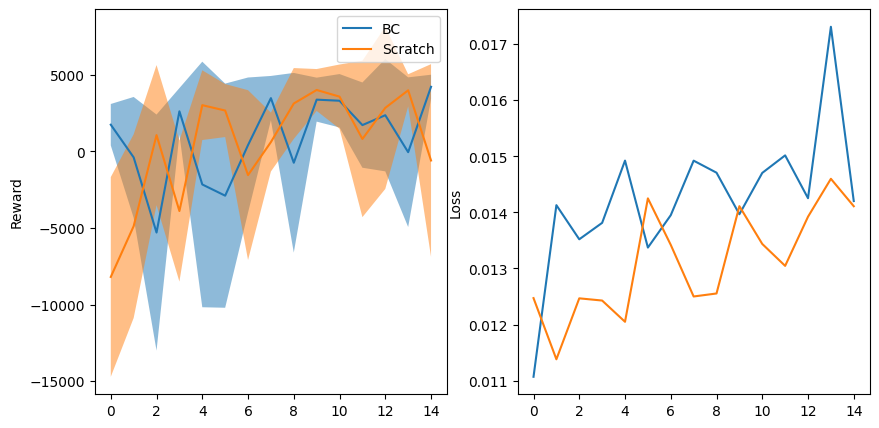

In [27]:
# Run DAgger starting from agent pretrained on curated data data
expert = ExpertAgent("./experts/network_1mil.pt")
agent = bc_agent
buffer = bc_buffer
optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
losses_bc, means_bc, stds_bc = dagger(
    agent, optimizer, expert, env, buffer, 2000, 15, 2000, 128, 10
)

# Run DAgger starting from scratch, using the same expert
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
buffer = ReplayBuffer()
optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
seed_data(env, expert, buffer, 2000)
losses_scratch, means_scratch, stds_scratch = dagger(
    agent, optimizer, expert, env, buffer, 2000, 15, 2000, 128, 10)

plot(
    [np.arange(len(losses_bc)), np.arange(len(losses_scratch))],
    [means_bc, means_scratch],
    [stds_bc, stds_scratch],
    [losses_bc, losses_scratch],
    ["BC", "Scratch"],
    running_average=1,
)

**Analysis :**

We can see that both runs are learning as the average rewards are increasing throughout the iterations even if it's composed of ups and downs, going to around 3000 to 4000 after half of the iterations.

For the loss, we can say that the overall result is fine as both losses are under 0.05. However, we could find surprising the fact that the losses are increasing throughout the iterations. Infact, when the loss goes up might be because the agent is training on data that it hasn't seen before while when loss goes down might be because the agent is training on data it has already seen.

Even though both approaches have close performances, the starting from scratch one appears to be better. It can be explained because the pretrained agent is only expert on states he already know so starting from scratch encourages more the agent to explore the environment and learn a policy that generalizes well.

**Now, we will be using a new expert agent which was trained for more steps than the first one. Evaluate and visualize it below.**

In [28]:
expert_2mil = ExpertAgent("./experts/network_2mil.pt")
mean, std = evaluate_agent(expert_2mil, env, 10)
print(f"Expert mean return: {mean} +/- {std}")
create_video(vis_env, expert_2mil, "expert_2mil")

Expert mean return: 5819.825133746303 +/- 91.8300304785515
Moviepy - Building video /content/content/video/expert_2mil-episode-0.mp4.
Moviepy - Writing video /content/content/video/expert_2mil-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/content/video/expert_2mil-episode-0.mp4


### **IV)b) Exploring the effect of the effect of the strength of the expert on DAgger**

We now look at how the strength of the expert affects our imitation learned algorithm.
The `expert_1mil` and `expert_2mil` are both policies from the same training run, except
the `expert_1mil` was trained for 1 million steps and `expert_2mil` was trained for 2 million steps.

In [29]:
N_ITERS = 50
N_DATA_PER_ITER = 2000
N_GRADIENT_STEPS = 2000
expert_strength_data = {
    "all_means": [],
    "all_stds": [],
    "all_losses": [],
    "all_xs": [],
}
for expert in [expert_1mil, expert_2mil]:
    agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
    optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
    buffer = ReplayBuffer()
    seed_data(env, expert, buffer, 2000)

    # Run DAgger for the given expert
    losses, means, stds = dagger(agent, optimizer, expert, env, buffer, N_DATA_PER_ITER, N_ITERS, N_GRADIENT_STEPS)

    xs = np.arange(N_ITERS) + 1
    expert_strength_data["all_xs"].append(xs)
    expert_strength_data["all_means"].append(means)
    expert_strength_data["all_stds"].append(stds)
    expert_strength_data["all_losses"].append(losses)

Iteration 1 / 50: mean reward -632.5422078871053 +/- 2776.750103399151
Iteration 2 / 50: mean reward -2243.8233908629672 +/- 3981.3714865206066
Iteration 3 / 50: mean reward -695.1313235642026 +/- 4079.3367109687306
Iteration 4 / 50: mean reward 3975.4466576203276 +/- 678.7040881114666
Iteration 5 / 50: mean reward 994.6272331304597 +/- 2832.0174534089315
Iteration 6 / 50: mean reward 2077.756339409435 +/- 2982.1234991970277
Iteration 7 / 50: mean reward 310.6371047558208 +/- 3485.6124737489604
Iteration 8 / 50: mean reward 3818.107181962487 +/- 1484.969489757422
Iteration 9 / 50: mean reward 767.5245401786774 +/- 4532.734147860681
Iteration 10 / 50: mean reward 1525.6519451781203 +/- 2377.6183058743836
Iteration 11 / 50: mean reward 2006.0751306113518 +/- 1962.61205482136
Iteration 12 / 50: mean reward 1866.2579934178582 +/- 2095.291939916389
Iteration 13 / 50: mean reward 1993.453176637419 +/- 2630.8758095081143
Iteration 14 / 50: mean reward 1667.1891267033557 +/- 2213.9499412659056

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: ylabel='Reward'>, <Axes: ylabel='Loss'>], dtype=object))

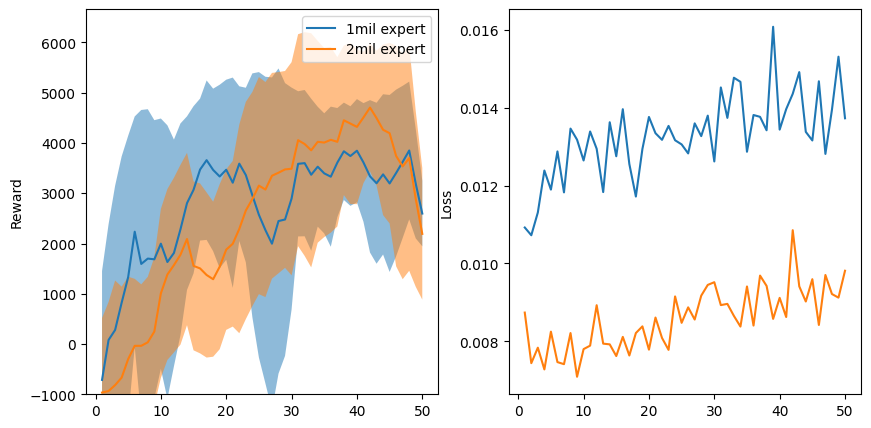

In [30]:
plot(
    expert_strength_data["all_xs"],
    expert_strength_data["all_means"],
    expert_strength_data["all_stds"],
    expert_strength_data["all_losses"],
    [f"{expert} expert" for expert in ["1mil", "2mil"]],
    min=-1000,
)

**Analysis :**

This solution seems to be correct as the rewards are increasing with the iterations and losses are under 0.05

As the stronger expert make us obtain a better average reward and a lower loss we can say that training the agent on more steps is relevant. However, this number of steps has to be monitored as when we will exceed a certain number it may make our solution overfitting.

### **IV)c) Exploring the effect of the number of iterations on DAgger**

We will now look at how the frequency of the number of DAgger iterations affects the
performance.

In [31]:
TOTAL_DATA = 100_000
TOTAL_GRADIENT_STEPS = 100_000
n_iters_data = {
    "all_means": [],
    "all_stds": [],
    "all_losses": [],
    "all_xs": [],
}
expert = ExpertAgent("./public/a2/experts/network_2mil.pt")
for n_iters in [5, 25, 50, 100, 200]:
    agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
    optimizer = torch.optim.Adam(agent.parameters(), lr=5e-3)
    buffer = ReplayBuffer()
    seed_data(env, expert, buffer, 2000)

    # Run DAgger for n_iters iterations
    losses, means, stds = dagger(
        agent,
        optimizer,
        expert,
        env,
        buffer,
        TOTAL_DATA // n_iters,
        n_iters,
        TOTAL_GRADIENT_STEPS // n_iters
    )

    xs = 100_000 / n_iters * (np.arange(n_iters) + 1)
    n_iters_data["all_xs"].append(xs)
    n_iters_data["all_means"].append(means)
    n_iters_data["all_stds"].append(stds)
    n_iters_data["all_losses"].append(losses)

Iteration 1 / 5: mean reward 580.1268578632139 +/- 1701.4408603377801
Iteration 2 / 5: mean reward 1912.6636947512209 +/- 1644.0228853502265
Iteration 3 / 5: mean reward 4333.35215119615 +/- 2054.5617635735844
Iteration 4 / 5: mean reward 5555.257497062195 +/- 412.58435675108944
Iteration 5 / 5: mean reward 3903.4426717878937 +/- 2146.0905634078476

Iteration 1 / 25: mean reward -1324.3693516212654 +/- 2303.9332791268293
Iteration 2 / 25: mean reward -778.3032022901614 +/- 1499.7281888980606
Iteration 3 / 25: mean reward -84.88313594367864 +/- 1321.3498787457409
Iteration 4 / 25: mean reward -301.94586635691076 +/- 2233.8599275561132
Iteration 5 / 25: mean reward 1789.2066963083787 +/- 1945.1368505501566
Iteration 6 / 25: mean reward 96.22108017460302 +/- 1458.3240960890319
Iteration 7 / 25: mean reward 369.8057946786078 +/- 1894.4701095897808
Iteration 8 / 25: mean reward 3100.2485626462135 +/- 2076.1951735712973
Iteration 9 / 25: mean reward 3515.5670181811483 +/- 2524.3766179693002


(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: ylabel='Reward'>, <Axes: ylabel='Loss'>], dtype=object))

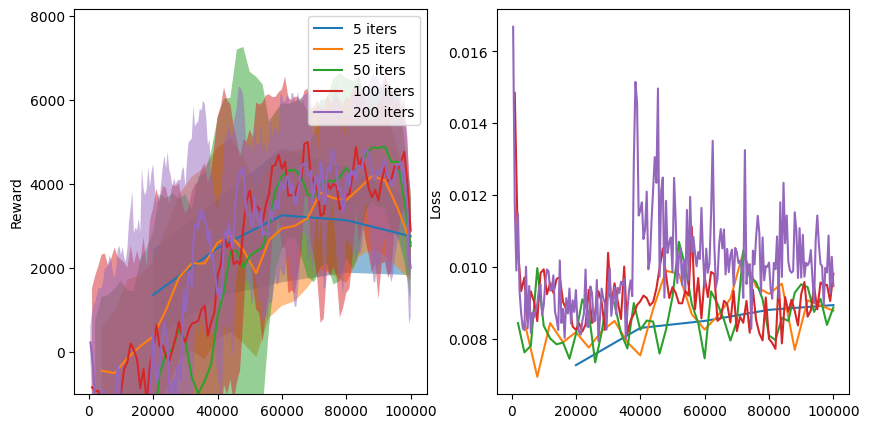

In [32]:
plot(
    n_iters_data["all_xs"],
    n_iters_data["all_means"],
    n_iters_data["all_stds"],
    n_iters_data["all_losses"],
    [f"{n_iters} iters" for n_iters in [5, 25, 50, 100, 200]],
    min=-1000,
)

**Analysis :**

This solution seems to be correct as the rewards are increasing with the amount of covered data and losses are under 0.05

We can see here that the number of iterations has a real impact on DAgger algorithm results.
On the one hand, a little number of iterations leads to lower loss but lower rewards too, it seems to be a case of underfitting.
On the other hand, a big number of iterations leads to higher rewards but higher loss too like it is overfitting.
So it's mandatory to find the better number of iterations by experimentation like it seems to be 50 here.